In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [21]:
# Create images with random rectangles and bounding boxes. 
num_imgs = 50000

img_size = 8
min_object_size = 1
max_object_size = 4
num_objects = 1

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))  # set background to 0

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.  # set rectangle to 1
        bboxes[i_img, i_object] = [x, y, w, h]
        
imgs.shape, bboxes.shape

((50000, 8, 8), (50000, 1, 4))

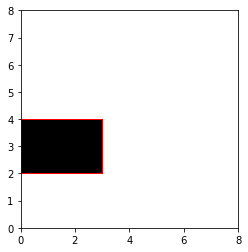

In [22]:
i = 0
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

In [23]:
# Reshape and normalize the image data to mean 0 and std 1. 
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((50000, 64), 6.075140390748857e-17, 1.0)

In [24]:
# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

((50000, 4), 0.280843125, 0.174788796881363)

In [25]:
# Split training and test.
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

In [27]:
# Build the model.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
model = Sequential([
        Dense(200, input_dim=X.shape[-1]), 
        Activation('relu'), 
        Dropout(0.2), 
        Dense(y.shape[-1])
    ])
model.compile('adadelta', 'mse')

In [29]:
# Train.
model.fit(train_X, train_y, epochs=30, validation_data=(test_X, test_y), verbose=2)

Epoch 1/30
1250/1250 - 2s - loss: 0.5776 - val_loss: 0.3877 - 2s/epoch - 1ms/step
Epoch 2/30
1250/1250 - 1s - loss: 0.4401 - val_loss: 0.2778 - 1s/epoch - 1ms/step
Epoch 3/30
1250/1250 - 1s - loss: 0.3538 - val_loss: 0.2118 - 1s/epoch - 1ms/step
Epoch 4/30
1250/1250 - 1s - loss: 0.3010 - val_loss: 0.1728 - 1s/epoch - 1ms/step
Epoch 5/30
1250/1250 - 1s - loss: 0.2686 - val_loss: 0.1489 - 1s/epoch - 1ms/step
Epoch 6/30
1250/1250 - 1s - loss: 0.2490 - val_loss: 0.1324 - 1s/epoch - 1ms/step
Epoch 7/30
1250/1250 - 1s - loss: 0.2333 - val_loss: 0.1201 - 1s/epoch - 1ms/step
Epoch 8/30
1250/1250 - 1s - loss: 0.2211 - val_loss: 0.1100 - 1s/epoch - 1ms/step
Epoch 9/30
1250/1250 - 1s - loss: 0.2094 - val_loss: 0.1016 - 1s/epoch - 1ms/step
Epoch 10/30
1250/1250 - 2s - loss: 0.2011 - val_loss: 0.0944 - 2s/epoch - 1ms/step
Epoch 11/30
1250/1250 - 2s - loss: 0.1938 - val_loss: 0.0880 - 2s/epoch - 1ms/step
Epoch 12/30
1250/1250 - 2s - loss: 0.1860 - val_loss: 0.0824 - 2s/epoch - 2ms/step
Epoch 13/30
1

In [30]:
# Predict bounding boxes on the test images.
pred_y = model.predict(test_X)
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 1, 4)

In [31]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

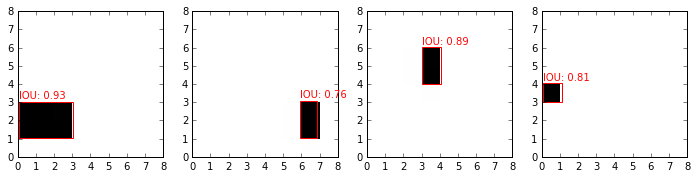

In [22]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
        
# plt.savefig('plots/bw-single-rectangle_prediction.png', dpi=300)

In [23]:
# Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

0.88166504246337463